In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from datetime import datetime, timedelta

# default plotting settings
#plt.rc('figure', figsize=(8.27,11.69))  # din a4 size in inches

# Temperature Anomalies Maps

This notebook visualises **temperature** anomalies for Europe and Northern Africa. I wish to plot quite recent data (December 2020 to August 2021), hence, I can't use [CRU TS](https://doi.org/10.1038/s41597-020-0453-3). Alternatively, the [ERA5](https://climatedataguide.ucar.edu/climate-data/era5-atmospheric-reanalysis) (atmospheric reanalysis) contains both temperature and precipitation data and is available until 2021/12. The dataset can be downloaded by request from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).

In [2]:
# load data from netCDF file
era5_file = Dataset('../../data/ERA5/era5_global_tmp-pre_2000-21.nc')
print(era5_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-03-22 12:43:58 GMT by grib_to_netcdf-2.24.2: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1647952849.8090181-25999-3-2b1ddad9-3469-43a1-aea6-d57bf674b058.nc /cache/tmp/2b1ddad9-3469-43a1-aea6-d57bf674b058-adaptor.mars.internal-1647952700.8968768-25999-2-tmp.grib
    dimensions(sizes): longitude(3600), latitude(1801), time(264)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


Temperature of air at 2m above the surface of land, sea or in-land waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

In [3]:
# variable information
cru_vars = [var for var in era5_file.variables]
for var in cru_vars:
    print('variable:', era5_file.variables[var],'\n')

variable: <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (3600,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (1801,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (264,)
filling on, default _FillValue of -2147483647 used 

variable: <class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.0017107202069085185
    add_offset: 259.1871405505411
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimited dimensions: 
curren

In [4]:
# get the data
# NOTE: taking every 10th coord due to computing power limitations
t2m = era5_file.variables['t2m'][:,::10,::10]
lon = era5_file.variables['longitude'][::10]
lat = era5_file.variables['latitude'][::10]
print(t2m.shape)
print(lon.shape) # from -180 to 179
print(lat.shape) # from -90 to 90 (including 0°)

(264, 181, 360)
(360,)
(181,)


In [5]:
# import time var & convert into datetime object
time = era5_file.variables['time'][:]

dtime = []
start = datetime(1900, 1, 1)
for t in time:
    delta = timedelta(hours=int(t))
    dtime.append(start + delta)

In [9]:
# write function to get indices of time intervals as we'll need this a couple
# of times
def get_indices(start, end):
    iout = []
    for i, time in enumerate(dtime):
        if time >= start and time <= end:
            iout.append(i)
    return iout

In [13]:
# get indices of years 2000/01-2020/01, i.e., reference period
start = datetime(2000, 1, 1)
end = datetime(2019, 12, 31)
iavg = get_indices(start, end)

# compute AVERAGE temperature per month per grid cell in reference period
t2m_avg = []
iend = iavg[-1]    # index of last month in ref period
for istart in iavg[:12]:    
    # loop over first 12 indices, then, compute mean from first to last index
    # using every 12th value! To include last month of reference period use "iend+1".
    monthly_mean = np.mean(t2m[istart:iend+1:12], axis=0)
    t2m_avg.append(monthly_mean)    # returns list of arrays of shape (12, 181, 360)
np.shape(t2m_avg)

(12, 181, 360)

In [68]:
# compute temperature ANOMALY with index of month for 2020/12 to 2021/08
start = datetime(2020, 12, 1)
end = datetime(2021, 8, 1)
ianom = get_indices(start, end)

t2m_anom = []
for i in ianom:
    imonth = dtime[i].month -1  # get index of month (e.g., Jan = 0, Dec = 11)
    monthly_anomaly = t2m[i] - t2m_avg[imonth]  # subtract respective month from tmp average
    t2m_anom.append(monthly_anomaly)
np.shape(t2m_anom)

(9, 181, 360)

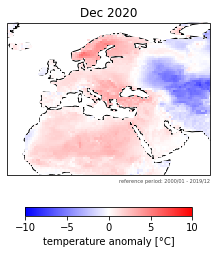

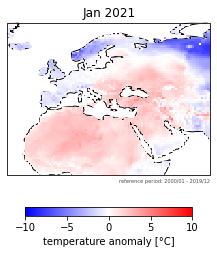

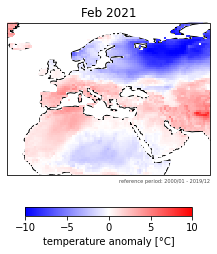

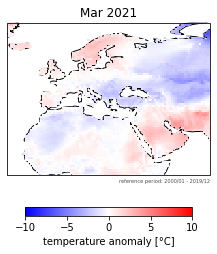

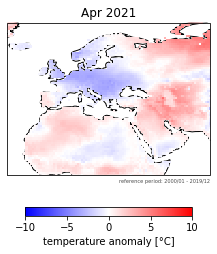

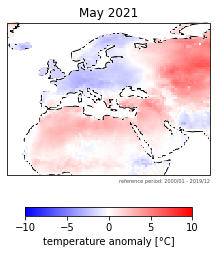

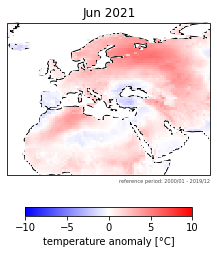

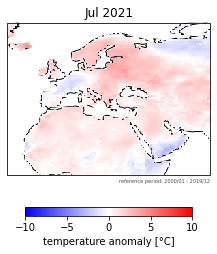

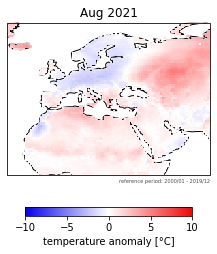

In [67]:
# plotting anomalies

# The data is defined in lat/lon coordinate system, so PlateCarree() is the
# appropriate transformation choice.
# (https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)
data_crs = ccrs.PlateCarree()
v = 10

llon, llat = np.meshgrid(lon, lat)
for i, idate in enumerate(ianom):
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 70, 5, 70])
    ax.set_title(dtime[idate].strftime('%b %Y'))
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.pcolormesh(lon, lat, t2m_anom[i], # alternatively: ax.contourf()
                        transform=data_crs, cmap='bwr', vmin=-v, vmax=v)
    cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.5)
    cb.set_label('temperature anomaly [°C]')
    ax.text(0.55,-.05,'reference period: 2000/01 - 2019/12',
            {'fontsize': 5, 'alpha': 0.7},
            transform=plt.gca().transAxes) # in axis coordinates
    fig.savefig(
        f'../figs/dragonflies-catalonia/tmp_{dtime[idate].year}-{dtime[idate].month}.png',
        dpi=600, bbox_inches='tight', facecolor='white',
    )

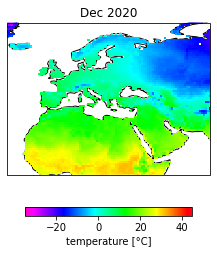

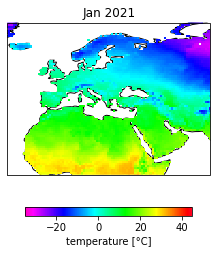

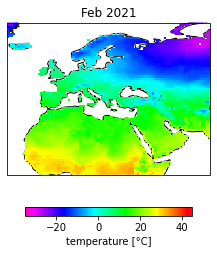

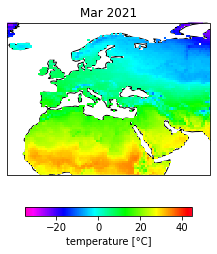

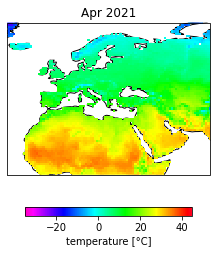

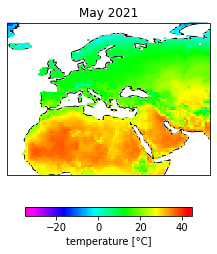

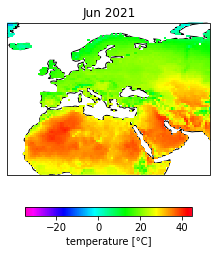

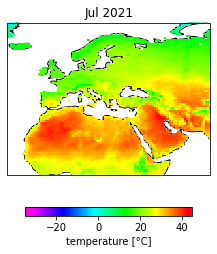

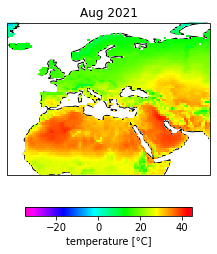

In [71]:
# plotting absolute temperature
data_crs = ccrs.PlateCarree()

llon, llat = np.meshgrid(lon, lat)
for i in ianom:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 70, 5, 70])
    ax.set_title(dtime[i].strftime('%b %Y'))
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.pcolormesh(lon, lat, t2m[i]-273.15, # alternatively: ax.contourf()
                        transform=data_crs, cmap='gist_rainbow_r', vmin=-35, vmax=45)
    cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.5)
    cb.set_label('temperature [°C]')
    fig.savefig(
        f'../figs/dragonflies-catalonia/tmp_{dtime[i].year}-{dtime[i].month}_abs.png',
        dpi=600, bbox_inches='tight', facecolor='white',
    )